In [2]:
import os
import math
import json


import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode, read_image


from icecream import ic

In [3]:
root_path = os.path.dirname(os.getcwd())
img_dir = f"{root_path}/images"

In [4]:
TRAIN_PERCENTAGE = 0.7
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 10

In [5]:
data: dict
with open(f"{img_dir}/images.json") as f:
    data = json.load(f)

len(data.keys())

201

TypeError: unhashable type: 'numpy.ndarray'

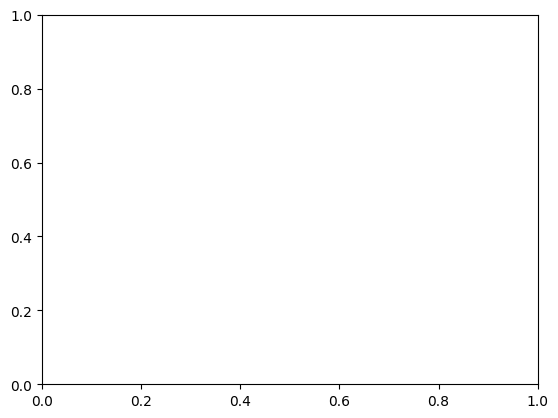

In [ ]:
selected_image = list(data.keys())[1]
example_img = f"{img_dir}/raw/{selected_image}"

image = cv2.imread(example_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.Canny(image, 50, 150, None, 3)
# image = cv2.resize(image, (512, 384))

corners = data[selected_image]["corners"]
height, width, _ = image.shape


image = cv2.Canny(image, 100, 200, None, 3)
cdst = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)
lines = cv2.HoughLines(image, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)


linesP = cv2.HoughLinesP(image, 1, np.pi / 180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)
# dot_size = image.shape[0] // 100
# for x, y in corners:
#     image = cv2.circle(
#         image, (int(width * x), int(height * y)), dot_size, (255, 0, 0), -1
#     )
plt.imshow("Source", cdst)
# plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

### Dataset

In [36]:
5712 // 10, 4284 // 10

(571, 428)

In [37]:
data_rows = []

for key, value in data.items():
    flattened_corners = [corner for sublist in value["corners"] for corner in sublist]
    data_rows.append((key, flattened_corners))

labels: pd.DataFrame = pd.DataFrame(data_rows, columns=["file", "corners"])

In [38]:
total_labels = labels.shape[0]
ic(total_labels)
amount_train_labels = int(total_labels * TRAIN_PERCENTAGE)


train_labels, test_labels = (
    labels[:amount_train_labels],
    labels[amount_train_labels:],
)
ic(len(train_labels))
ic(len(test_labels))

ic(test_labels.iloc[0])

ic| total_labels: 201
ic| len(train_labels): 140
ic| len(test_labels): 61
ic| test_labels.iloc[0]: file                                           IMG_1416.jpeg
                         corners    [0.2703081232492997, 0.2222222222222222, 0.721...
                         Name: 140, dtype: object


file                                           IMG_1416.jpeg
corners    [0.2703081232492997, 0.2222222222222222, 0.721...
Name: 140, dtype: object

In [39]:
class GoBoardDataset(Dataset):
    def __init__(self, labels: pd.DataFrame, transform=None):
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx):
        file_name, label = self.labels.iloc[idx]
        image = read_image(f"{img_dir}/raw/{file_name}", ImageReadMode.RGB)
        label = torch.tensor(label, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label


transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # ! has to be here otherwise you won't be able to display them later
        transforms.Resize((768, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
train_dataset = GoBoardDataset(train_labels, transform)
test_dataset = GoBoardDataset(test_labels, transform)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

## Neural Net

In [40]:
class CornerDetectionCNN(nn.Module):
    def __init__(self):
        super(CornerDetectionCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(64 * 96 * 128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [41]:
net = CornerDetectionCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [42]:
for epoch in range(EPOCHS):
    # Wrap the train_loader with tqdm to show progress, including the loss value
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")

    for images, targets in progress_bar:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update tqdm description with the current loss
        progress_bar.set_postfix(loss=loss.item())

Epoch 10/10: 100%|██████████| 8/8 [00:40<00:00,  5.02s/batch, loss=0.0185]


/var/folders/w7/7cx3tt4j6cx7ymjcjlg47w0c0000gn/T/ipykernel_45667/3049118793.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]


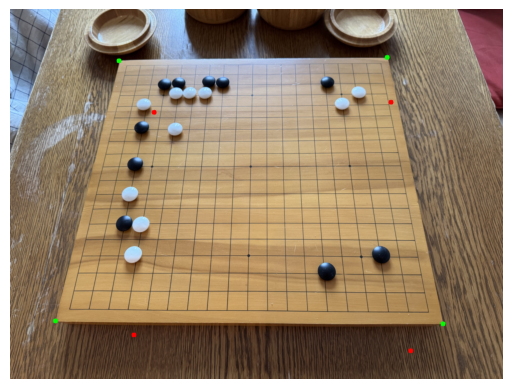

In [47]:
with torch.no_grad():
    for data in test_loader:
        images, label = data

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        selected_index = 3
        image = images[selected_index]
        labels = label[selected_index].tolist()
        predicted_corners = outputs[selected_index].tolist()

        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        unnormalized_tensor = (
            image * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
        )
        image = unnormalized_tensor.numpy().transpose(1, 2, 0)
        image = (image * 255).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape
        dot_size = 5

        for i in range(4):
            x, y = labels[i * 2], labels[i * 2 + 1]
            image = cv2.circle(
                image, (int(width * x), int(height * y)), dot_size, (0, 255, 0), -1
            )

            x, y = predicted_corners[i * 2], predicted_corners[i * 2 + 1]
            image = cv2.circle(
                image, (int(width * x), int(height * y)), dot_size, (0, 0, 255), -1
            )

        # Convert back to RGB for displaying with matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.axis("off")
        plt.show()

        break

In [46]:
import torch

with torch.no_grad():
    total_error = 0
    total_samples = 0

    for data in test_loader:
        images, label = data

        outputs = net(images)

        batch_error = torch.abs(outputs - label).mean()

        total_error += batch_error.item()
        total_samples += 1

    average_error = total_error / total_samples
    print(f"Average Error: {average_error}")

Average Error: 0.10144800692796707
